# __Quickstart__

In this notebook, we cover the basic usage of `adelie`.
We assume that the reader is familiar with the group elastic net problem.
For an introduction to group elastic net, we refer the readers to 
[Introduction to Group Elastic Net](./introduction.ipynb).

In [1]:
import adelie as ad
import numpy as np
import matplotlib.pyplot as plt

## __Gaussian Group Elastic Net__

Before using `adelie`, we assume that the user has a feature matrix `X` and a response vector `y`.
For simplicity, we assume for now that `X` is a dense matrix,
although we will later see that `X` can be substituted with a custom matrix as well.
For demonstration, we will randomly generate our data.

In [2]:
n = 100     # number of observations
p = 1000    # number of features
seed = 0    # seed

np.random.seed(seed)
X = np.random.normal(0, 1, (n, p))
y = X[:, -1] * np.random.normal(0, 1) + np.random.normal(0, 1, n)

### __Lasso__

The most basic call to `ad.grpnet` simply supplies a `X` matrix and a `glm` object.
For example, `ad.glm.gaussian()` returns a Gaussian GLM object,
which corresponds to the usual least squares loss function.
By default, `ad.grpnet` will fit lasso by setting each feature as its own group.
`adelie` is written to treat groups of size `1` in a more optimized manner,
so it is a competitive lasso solver as well.
`grpnet` will also generate a sequence of 100 regularizations $\lambda$ 
evenly spaced on the log scale by default if the user does not provide the path.
Since `grpnet` is a path-solver, it will warm-start at the next $\lambda$
using the current solution on the path.
__For this reason, we recommend users to supply a sufficiently fine grid of__ $\lambda$ __or use the default path!__

In [3]:
state = ad.grpnet(
    X=X,
    glm=ad.glm.gaussian(y=y),
)

 46%|█████     | 46/100 [00:00:00<00:00:00, 3564.27it/s] [dev:90.6%]


Note that the solver finished early in this example.
We display a progress bar that indicates the number of $\lambda$'s processed,
time elapsed, time remaining, and the percent deviance explained.
By default, the solver terminates if the latter reaches $90\%$ as a simple heuristic to avoid overfitting.
This threshold can be controlled via the argument `adev_tol`.

The output of `ad.grpnet` is a _state_ object, which represents the state of the optimizer.
For most use-cases, the users do not need to inspect the internals of a state object,
with some exceptions:

In [4]:
state.betas         # (L, p) sparse matrix of solutions (one for each row)
state.intercepts    # (L,) intercepts
state.devs          # (L,) vector of % deviance explained
state.lmdas         # (L,) regularization at each saved solution
assert True         # barrier to not output anything

Otherwise, we recommend users to use our diagnostic class,
`ad.diagnostic.diagnostic`, to visualize aspects of the state.

In [5]:
dg = ad.diagnostic.diagnostic(state=state)

For example, we can plot the coefficients and the percent deviance explained.

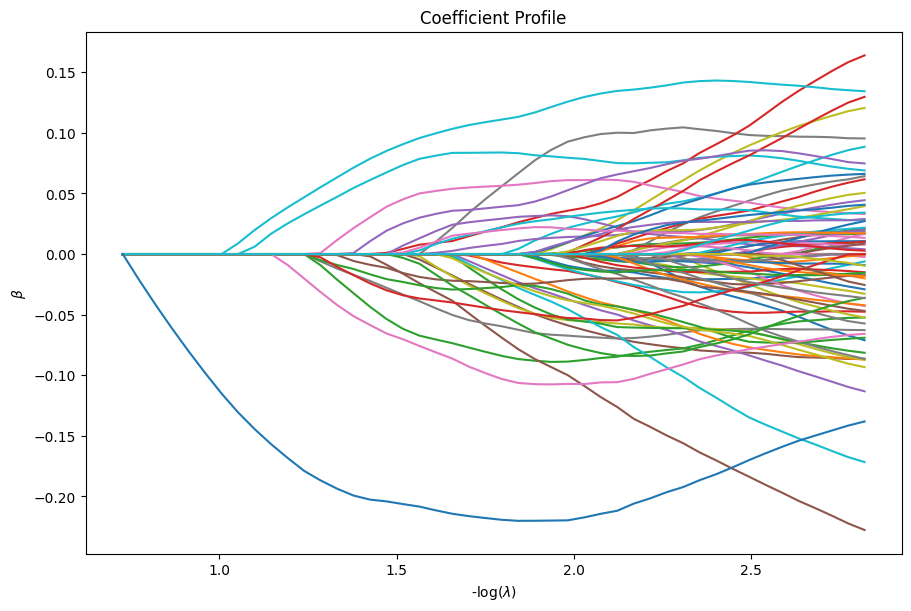

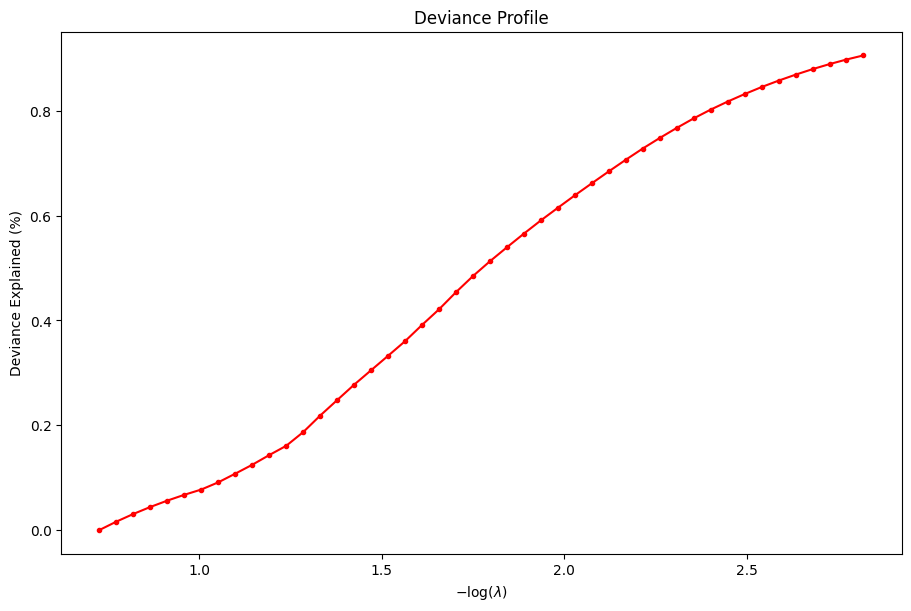

In [6]:
dg.plot_coefficients()
dg.plot_devs()
plt.show()

Serious developers may be interested in the performance of the solver.
We also provide a function to inspect the benchmark timings of the solver at each $\lambda$.

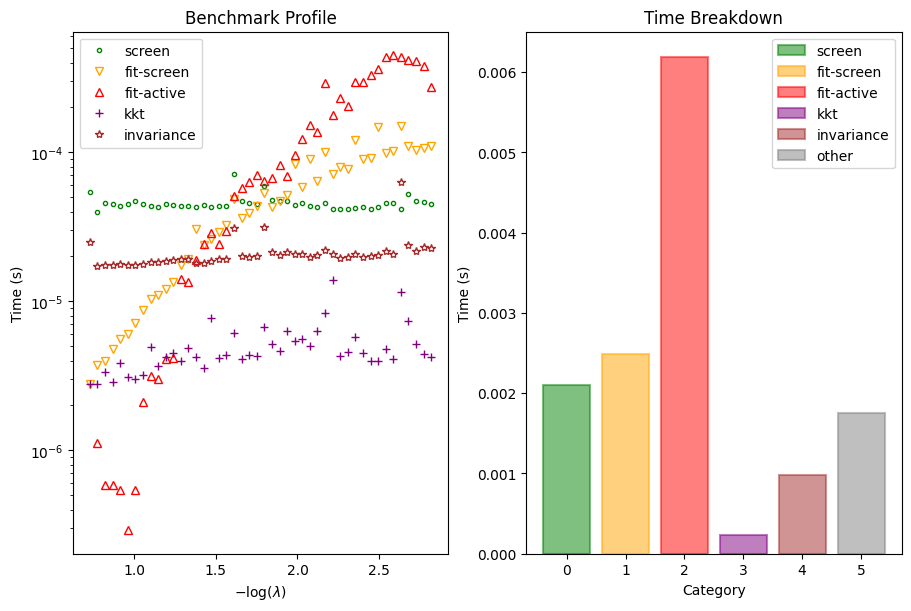

In [7]:
dg.plot_benchmark()
plt.show()

### __Group Lasso__

To fit group lasso, the user simply needs to supply a `groups` argument that
defines the starting column index of $X$ for each group.
For example, if there are `4` features with two (contiguous) groups of sizes `3` and `1`, respectively,
then `groups = [0, 3]`.
For demonstration, we take the same data as before and group every `10` features.
We then fit group lasso using the same function.

In [8]:
state = ad.grpnet(
    X=X,
    glm=ad.glm.gaussian(y=y),
    groups=10*np.arange(X.shape[-1] // 10),
)

 38%|████      | 38/100 [00:00:00<00:00:00, 5126.30it/s] [dev:90.1%]


As before, we may inspect the same elements of `state` and diagnostics.

In [9]:
dg = ad.diagnostic.diagnostic(state=state)

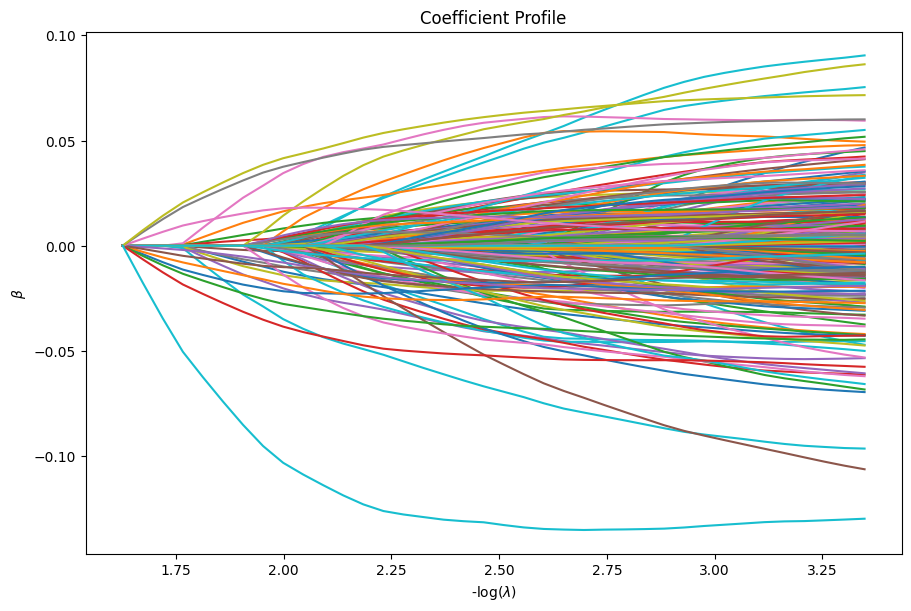

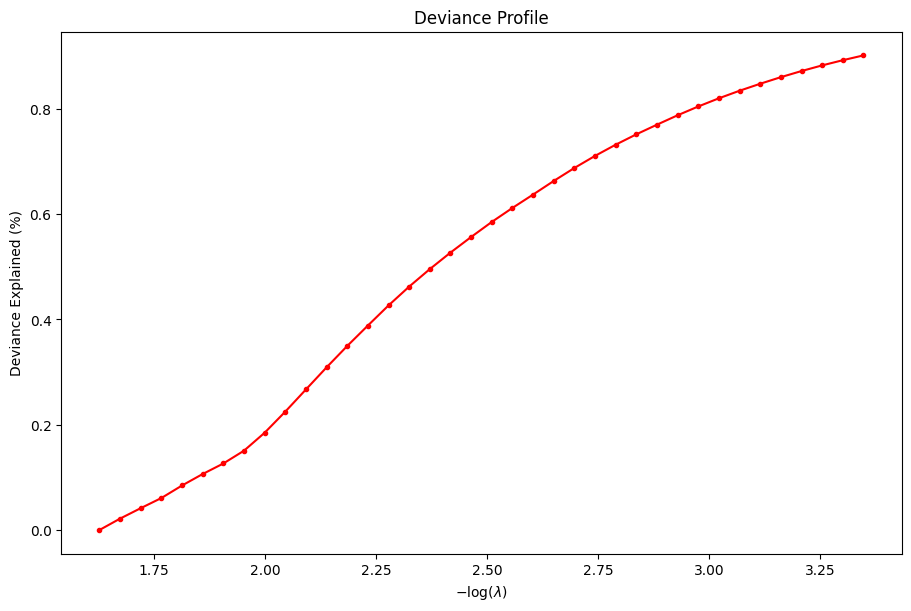

In [10]:
dg.plot_coefficients()
dg.plot_devs()
plt.show()

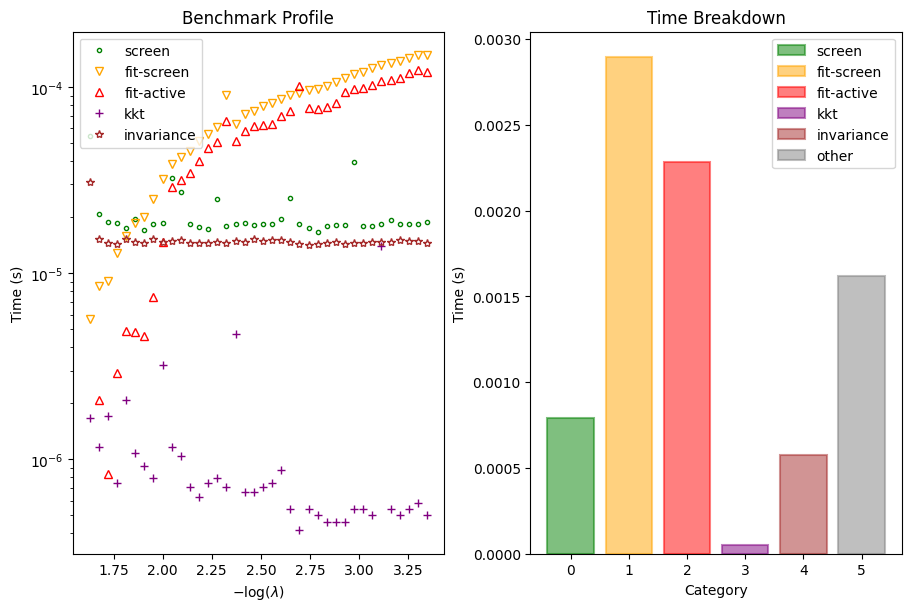

In [11]:
dg.plot_benchmark()
plt.show()

### __Covariance Method__

For least squares specifically, we expose an equivalent solver `ad.solver.gaussian_cov` that 
uses summary statistics rather than individual-level data.

We show below how to solve the equivalent problem presented in the previous sections.
First, we create the summary statistics based on the individual-level data.

In [12]:
Xc = X - np.mean(X, axis=0)[None]
yc = y - np.mean(y)
A = Xc.T @ Xc / n
v = Xc.T @ yc / n

Now, we use `gaussian_cov` to solve the Gaussian group elastic net problem.

In [13]:
state_cov = ad.gaussian_cov(
    A=A,
    v=v,
    groups=10*np.arange(A.shape[-1] // 10),
)

 63%|██████    | 63/100 [00:00:00<00:00:00, 452.93it/s] [rdev:0.1%]


Note that the progress bar displays a different measurement of deviance explained.
For the covariance method, since it is usually infeasible to compute the loss at the saturated model,
we only display the relative change in percent deviance explained
(which can be computed without knowledge of the saturated loss):
$$
\begin{align*}
    \mathrm{rdev} 
    := 
    \frac{
        \ell(\beta_{\mathrm{prev}}) - \ell(\beta_{\mathrm{curr}})
    }{
        \ell(\beta_{\mathrm{null}}) - \ell(\beta_{\mathrm{curr}})
    }
\end{align*}
$$
so that a $\mathrm{rdev}$ close to zero indicates overfitting.
In this example, we early exit the solver once $\mathrm{rdev}$ reaches $0.1\%$.

We can compare the solution with that of the result of `grpnet` from before.

In [14]:
n_common_sols = min(state_cov.betas.shape[0], state.betas.shape[0])
assert np.allclose(
    state_cov.betas[:n_common_sols].toarray(),
    state.betas[:n_common_sols].toarray(),
    atol=1e-3,
)

## __GLM Group Elastic Net__

In the previous section, we covered how to solve penalized least squares regression.
Nearly all of the content remains the same for fitting penalized GLM regression.
The only difference is in the choice of the `glm` object.
For brevity, we only discuss logistic regression as our non-trivial GLM example,
however the following discussion applies for any GLM.

Let's generate our dataset for logistic regression.

In [15]:
n = 100     # number of observations
p = 1000    # number of features
seed = 0    # seed

np.random.seed(seed)
X = np.random.normal(0, 1, (n, p))
eta = X[:, -1] * np.random.normal(0, 1) + np.random.normal(0, 1, n)
mu = 1 / (1 + np.exp(-eta))
y = np.random.binomial(1, mu)

To solve the group elastic net problem using the logistic loss,
we simply provide the Binomial GLM object.
For simplicity, we fit the lasso problem below.

In [16]:
state = ad.grpnet(
    X=X,
    glm=ad.glm.binomial(y=y),
)

 57%|██████    | 57/100 [00:00:00<00:00:00, 2702.83it/s] [dev:90.2%]


As before, the user may inspect diagnostic elements of the state in the same fashion.

## __Multi-Response GLM Elastic Net__

`ad.grpnet` is also able to fit multi-response GLM elastic net.
Currently, we only support Multigaussian (least squares) and Multinomial GLMs.
The only difference in the API from the single-response case 
is that `groups` argument only takes two possible values:
`"grouped"` or `"ungrouped"`.
If `groups="grouped"` (default), then for each feature, 
the corresponding coefficients across the responses are grouped.
Otherwise, every coefficient is in its own group.

The following code shows an example of fitting a multi-response least squares group elastic net.
For simplicity, we fit the lasso problem.

In [17]:
n = 100     # number of observations
p = 1000    # number of features
K = 4       # number of responses
seed = 0    # seed

np.random.seed(seed)
X = np.random.normal(0, 1, (n, p))
y = X[:, -1:] @ np.random.normal(0, 1, (1, K)) + np.random.normal(0, 1, (n, K))

In [18]:
state = ad.grpnet(
    X=X,
    glm=ad.glm.multigaussian(y=y),
)

 61%|██████    | 61/100 [00:00:00<00:00:00, 1127.60it/s] [dev:90.2%]


Another important difference from the single-response case is that 
the user must be aware of the shape of the returned coefficients.
For multi-response GLMs, the intercept (if `intercept=True`) is added for each response.
Hence, `state.intercepts` will be a `(L, K)` matrix.
Moreover, `state.betas` will be a `(L, pK)` sparse matrix where every `K` columns correspond to the
coefficients associated with a feature and across all responses.
So, `state.betas[i, :K]` are the coefficients for the `i` th solution on the path and first feature.

In [19]:
(
    state.intercepts.shape,
    state.betas.shape,
)

((61, 4), (61, 4000))

For completion, we show an example of fitting a multinomial group elastic net.
For simplicity, we fit the lasso problem.

In [20]:
n = 100     # number of observations
p = 1000    # number of features
K = 4       # number of responses
seed = 0    # seed

np.random.seed(seed)
X = np.random.normal(0, 1, (n, p))
eta = X[:, -1:] @ np.random.normal(0, 1, (1, K)) + np.random.normal(0, 1, (n, K))
mu = np.exp(eta) / np.sum(np.exp(eta), axis=-1)[:, None]
y = np.array([np.random.multinomial(1, m) for m in mu])

In [21]:
state = ad.grpnet(
    X=X,
    glm=ad.glm.multinomial(y=y),
)

 52%|█████     | 52/100 [00:00:00<00:00:00, 450.28it/s] [dev:90.2%]


## __Global Configurations__

Global configurations can be toggled via `ad.configs.set_configs` function.

To change the progress bar symbol, the user can run the following with the last argument being the desired symbol:

In [22]:
ad.configs.set_configs("pb_symbol", "\U0001f427")

Now, the progress bar will print penguins!

In [23]:
state = ad.grpnet(
    X=X,
    glm=ad.glm.multinomial(y=y),
)

 52%|🐧🐧🐧🐧🐧     | 52/100 [00:00:00<00:00:00, 484.31it/s] [dev:90.2%]
